In [2]:
import pandas
import os
import numpy as np


df = pandas.read_csv("1335.vdb.tab", sep="\t", header =None) 
#Récupère la liste de nombre, correspondant aux comptage des différents espèces en fonction des lieu de prélevement
#2=door_in_1 ; 3=door_in_2 ; 4=faucet_handle_1 ; 5=faucet_handle_2 ; 6=sink_floor_1 ; 7=sink_floor_2
#8=soap_dispenser_1 ; 9=stall_in_1 ; 10=toilet_floor_1 ; 11=toilet_floor_1 ; 12=toilet_flush_handle_1
#13=toilet_flush_handle_2 ; 14=toilet_seat_1 ; 15=toilet_seat_2
def getcountsfromrow(row):
    l_l = [ int(row[2]),
            int(row[3]),
            int(row[4]),
            int(row[5]),
            int(row[6]),
            int(row[7]),
            int(row[8]),
            int(row[9]),
            int(row[10]),
            int(row[11]),
            int(row[12]),
            int(row[13]),
            int(row[14]),
            int(row[15]) ]
    return l_l

"""
Code pour generer dictionnaire. 

Au prealable, avec cat 1335.vdb.tab | cut -f 2 | cut -d ";" -f 1 | uniq
OTUConTaxonomy"Bacteria(100)  => on a confirmé que ce sont toutes Bacteria
"""
def getDicoTaxo(df):
    dicotaxo = { "name" : "Bacteria", "count" : [0 for i in range(14)], "children" : []}
    for index,row in df.iterrows():
        leveltax = row[1].split(';')  # uniquement indexes >=1 m'interessent 
        if index > 0:
            COUNTS = getcountsfromrow(row)
            tmp5 = {}
            tmp4 = {}
            tmp3 = {}
            tmp2 = {}
            tmp1 = {}
            tmp5["name"] = leveltax[5]
            tmp4["name"] = leveltax[4]
            tmp3["name"] = leveltax[3]
            tmp2["name"] = leveltax[2]
            tmp1["name"] = leveltax[1]      
            tmp5["count"] =  getcountsfromrow(row)
            tmp5["children"] = []  # lowest level
            tmp4["count"] =  getcountsfromrow(row)
            tmp4["children"] = [tmp5]
            tmp3["count"] =  getcountsfromrow(row)
            tmp3["children"] = [tmp4]
            tmp2["count"] =  getcountsfromrow(row)
            tmp2["children"] = [tmp3]
            tmp1["count"] = getcountsfromrow(row)
            tmp1["children"] = [tmp2]
            tmpcounts = dicotaxo["count"]
            dicotaxo["count"] = np.add(tmpcounts, COUNTS)
            if leveltax[1] not in [m["name"] for m in dicotaxo["children"]] :
                dicotaxo["children"].append(tmp1)
            else:
                for m in dicotaxo["children"]:
                    if m["name"] == leveltax[1]:
                        tmpc = m["count"]
                        m["count"] = np.add(tmpc, COUNTS)
                        if leveltax[2] not in [n["name"] for n in m["children"]] :
                            m["children"].append(tmp2)
                        else:
                            for n in m["children"]:
                                if n["name"] == leveltax[2]:
                                    tmpc = n["count"]
                                    n["count"] = np.add(tmpc, COUNTS)
                                    if leveltax[3] not in [o["name"] for o in n["children"]]:
                                        n["children"].append(tmp3)
                                    else: 
                                        for o in n["children"]:
                                            if o["name"] == leveltax[3]:
                                                tmpc = o["count"]
                                                o["count"] = np.add(tmpc,COUNTS)
                                                if leveltax[4] not in [p["name"] for p in o["children"]]:
                                                    o["children"].append(tmp4)
                                                else:
                                                    for p in o["children"]:
                                                        if p["name"] == leveltax[4]:
                                                            tmpc = p["count"]
                                                            p["count"] = np.add(tmpc, COUNTS)
                                                            if leveltax[5] not in [q["name"] for q in p["children"]]:
                                                                p["children"].append(tmp5)
                                                            else:
                                                                for q in p["children"]:
                                                                    if q["name"] == leveltax[5]:
                                                                        tmpc = q["count"]
                                                                        q["count"] = np.add(tmpc, COUNTS)
                                                                        q["children"] = []
                                                                        # this is the lowest level                                        
    return dicotaxo




In [3]:
"""
Veut pouvoir récuperer donnée intéressantes dans dictionnaire.
"""

def convertNiv(niveau):
    if niveau.upper() == "REGNE":
        return 1
    if niveau.upper() == "PHYLUM":
        return 2
    if niveau.upper() == "CLASSE":
        return 3
    if niveau.upper() == "ORDRE":
        return 4
    if niveau.upper() == "FAMILLE":
        return 5
    if niveau.upper() == "GENRE":
        return 6
    
def dicoListeNiveau(nomList, dico):
    dico[nomList] = []
    
#Méthode 1 : En fonction du niveaux de taxo récupéré donnne pour l'espèce le comptage en fonction du lieu
#Input : niveau taxo Regne;Phylum;Classe;Ordre;Famille;Genre
#Output : liste de vecteurs 1er : vecteur des espèces, 
#puis 1 vecteurs par localisation (1 vecteur donne le comptage pour l'espèce dans la localisation donnée)
def getNiv(niveau,dicoTaxo):
    niv = convertNiv(niveau)
    vecteurs = []
    dicoListeNivx = {}
    #Regne 
    listeRegne = []
    #Regne compte
    listelRegne = []
    #Autre niveau
    listePhylum =[]
    listeClasse =[]
    listeOrdre =[]
    listeFamille =[]
    listeGenre =[]
    #autre niveau compte
    for i in range(1,15):
        nomList = f"listel{i}" + niveau.lower()
        dicoListeNiveau(nomList,dicoListeNivx )

    for k1, v1 in dicoTaxo.items():
        #Récupère que pour le règne
        if k1 == "name" and niv == 1:
            listeRegne.append(v1)
            vecteurs.append(listeRegne)
        elif k1 == "count" and niv == 1:
            listelRegne.append(v1)
            vecteurs.append(listelRegne)
        elif k1 == "children" and niv > 1: 
            for phylum in dicoTaxo['children']:
                for k2, v2 in phylum.items():
                    #Récupère que pour le phylum
                    if k2 == "name" and niv == 2:
                        listePhylum.append(v2)
                    elif k2 == "count" and niv == 2:
                        for i in range(0,14):
                            numList = i+1
                            nomList = f"listel{numList}" + niveau.lower()
                            dicoListeNivx[nomList].append(v2[i])

                    #Descend dans les niveau plus précis
                    elif k2 == "children" and niv > 2:
                        for classe in v2:
                            for k3, v3 in classe.items():
                                #Récupère que pour la classe
                                if k3 == "name" and niv == 3:
                                    listeClasse.append(v3)
                                elif k3 == "count" and niv == 3:
                                     for i in range(0,14):
                                        numList = i+1
                                        nomList = f"listel{numList}" + niveau.lower()
                                        dicoListeNivx[nomList].append(v3[i])
                                #Descend dans les niveau plus précis
                                elif k3 == "children" and niv > 3:
                                    for ordre in v3:
                                        for k4, v4 in ordre.items():
                                            #Récupère que pour l'ordre
                                            if k4 == "name" and niv == 4:
                                                listeOrdre.append(v4)
                                            elif k4 == "count" and niv == 4:
                                                for i in range(0,14):
                                                    numList = i+1
                                                    nomList = f"listel{numList}" + niveau.lower()
                                                    dicoListeNivx[nomList].append(v4[i])
                                            #Descend dans les niveau plus précis
                                            elif k4 == "children" and niv > 4:
                                                for famille in v4:
                                                    for k5, v5 in famille.items():
                                                        #Récupère que pour la famille
                                                        if k5 == "name" and niv == 5:
                                                            listeFamille.append(v5)
                                                        elif k5 == "count" and niv == 5:
                                                            for i in range(0,14):
                                                                numList = i+1
                                                                nomList = f"listel{numList}" + niveau.lower()
                                                                dicoListeNivx[nomList].append(v5[i])
                                                        #Descend dans les niveau plus précis
                                                        elif k5 == "children" and niv > 5:
                                                            for genre in v5:
                                                                for k6, v6 in genre.items():
                                                                    #Récupère que pour la famille
                                                                    if k6 == "name" and niv == 6:
                                                                        listeGenre.append(v6)
                                                                    elif k6 == "count" and niv == 6:
                                                                        for i in range(0,14):
                                                                            numList = i+1
                                                                            nomList = f"listel{numList}" + niveau.lower()
                                                                            dicoListeNivx[nomList].append(v6[i])
                                                                    

    
    if niv == 2:
        vecteurs.append(listePhylum);vecteurs.append(dicoListeNivx['listel1phylum']);vecteurs.append(dicoListeNivx['listel2phylum']);vecteurs.append(dicoListeNivx['listel3phylum'])
        vecteurs.append(dicoListeNivx['listel4phylum']);vecteurs.append(dicoListeNivx['listel5phylum']);vecteurs.append(dicoListeNivx['listel6phylum']);vecteurs.append(dicoListeNivx['listel7phylum'])
        vecteurs.append(dicoListeNivx['listel8phylum']);vecteurs.append(dicoListeNivx['listel9phylum']);vecteurs.append(dicoListeNivx['listel10phylum']);vecteurs.append(dicoListeNivx['listel11phylum'])
        vecteurs.append(dicoListeNivx['listel12phylum']);vecteurs.append(dicoListeNivx['listel13phylum']);vecteurs.append(dicoListeNivx['listel14phylum']);
    if niv == 3:
        vecteurs.append(listeClasse);vecteurs.append(dicoListeNivx['listel1classe']);vecteurs.append(dicoListeNivx['listel2classe']);vecteurs.append(dicoListeNivx['listel3classe'])
        vecteurs.append(dicoListeNivx['listel4classe']);vecteurs.append(dicoListeNivx['listel5classe']);vecteurs.append(dicoListeNivx['listel6classe']);vecteurs.append(dicoListeNivx['listel7classe'])
        vecteurs.append(dicoListeNivx['listel8classe']);vecteurs.append(dicoListeNivx['listel9classe']);vecteurs.append(dicoListeNivx['listel10classe']);vecteurs.append(dicoListeNivx['listel11classe'])
        vecteurs.append(dicoListeNivx['listel12classe']);vecteurs.append(dicoListeNivx['listel13classe']);vecteurs.append(dicoListeNivx['listel14classe']);
    if niv == 4:
        vecteurs.append(listeOrdre);vecteurs.append(dicoListeNivx['listel1ordre']);vecteurs.append(dicoListeNivx['listel2ordre']);vecteurs.append(dicoListeNivx['listel3ordre'])
        vecteurs.append(dicoListeNivx['listel4ordre']);vecteurs.append(dicoListeNivx['listel5ordre']);vecteurs.append(dicoListeNivx['listel6ordre']);vecteurs.append(dicoListeNivx['listel7ordre'])
        vecteurs.append(dicoListeNivx['listel8ordre']);vecteurs.append(dicoListeNivx['listel9ordre']);vecteurs.append(dicoListeNivx['listel10ordre']);vecteurs.append(dicoListeNivx['listel11ordre'])
        vecteurs.append(dicoListeNivx['listel12ordre']);vecteurs.append(dicoListeNivx['listel13ordre']);vecteurs.append(dicoListeNivx['listel14ordre']);
    if niv == 5:
        vecteurs.append(listeFamille);vecteurs.append(dicoListeNivx['listel1famille']);vecteurs.append(dicoListeNivx['listel2famille']);vecteurs.append(dicoListeNivx['listel3famille'])
        vecteurs.append(dicoListeNivx['listel4famille']);vecteurs.append(dicoListeNivx['listel5famille']);vecteurs.append(dicoListeNivx['listel6famille']);vecteurs.append(dicoListeNivx['listel7famille'])
        vecteurs.append(dicoListeNivx['listel8famille']);vecteurs.append(dicoListeNivx['listel9famille']);vecteurs.append(dicoListeNivx['listel10famille']);vecteurs.append(dicoListeNivx['listel11famille'])
        vecteurs.append(dicoListeNivx['listel12famille']);vecteurs.append(dicoListeNivx['listel13famille']);vecteurs.append(dicoListeNivx['listel14famille']);
    if niv == 6:
        vecteurs.append(listeGenre);vecteurs.append(dicoListeNivx['listel1genre']);vecteurs.append(dicoListeNivx['listel2genre']);vecteurs.append(dicoListeNivx['listel2genre'])
        vecteurs.append(dicoListeNivx['listel4genre']);vecteurs.append(dicoListeNivx['listel5genre']);vecteurs.append(dicoListeNivx['listel6genre']);vecteurs.append(dicoListeNivx['listel7genre'])
        vecteurs.append(dicoListeNivx['listel8genre']);vecteurs.append(dicoListeNivx['listel9genre']);vecteurs.append(dicoListeNivx['listel10genre']);vecteurs.append(dicoListeNivx['listel11genre'])
        vecteurs.append(dicoListeNivx['listel12genre']);vecteurs.append(dicoListeNivx['listel13genre']);vecteurs.append(dicoListeNivx['listel14genre']);
    
    return vecteurs

In [4]:
#Création df
def getDF(dicoTaxo):
    listeDf=[]
    listeRegne=["regne"]
    for k1, v1 in dicoTaxo.items():
        #Récupère que pour le règne
        if k1 == "name":
            listeRegne.append(v1)
        elif k1 == "count" :
            for i in range(0,14):
                listeRegne.append(int(v1[i]))
            listeDf.append(listeRegne)
        elif k1 == "children":
            for phylum in dicoTaxo['children']:
                listePhylum = ["phylum"]
                for k2, v2 in phylum.items():
                    #Récupère que pour le phylum
                    if k2 == "name" :
                        listePhylum.append(v2)
                    elif k2 == "count" :
                        for i in range(0,14):
                            listePhylum.append(int(v2[i]))
                        listeDf.append(listePhylum)
                    #Descend dans les niveau plus précis
                    elif k2 == "children" :
                        for classe in v2:
                            listeClasse = ["classe"]
                            for k3, v3 in classe.items():
                                #Récupère que pour le phylum
                                if k3 == "name" :
                                    listeClasse.append(v3)
                                elif k3 == "count" :
                                    for i in range(0,14):
                                        listeClasse.append(int(v3[i]))
                                    listeDf.append(listeClasse)
                                #Descend dans les niveau plus précis
                                elif k2 == "children" :
                                    for ordre in v3:
                                        listeOrdre = ["ordre"]
                                        for k4, v4 in ordre.items():
                                            #Récupère que pour le phylum
                                            if k4 == "name" :
                                                listeOrdre.append(v4)
                                            elif k4 == "count" :
                                                for i in range(0,14):
                                                    listeOrdre.append(int(v4[i]))
                                                listeDf.append(listeOrdre)
                                            #Descend dans les niveau plus précis
                                            elif k4 == "children" :
                                                for famille in v4:
                                                    listeFamille = ["famille"]
                                                    for k5, v5 in famille.items():
                                                        #Récupère que pour le phylum
                                                        if k5 == "name" :
                                                            listeFamille.append(v5)
                                                        elif k5 == "count" :
                                                            for i in range(0,14):
                                                                listeFamille.append(int(v5[i]))
                                                            listeDf.append(listeFamille)
                                                         #Descend dans les niveau plus précis
                                                        elif k5 == "children" :
                                                            for genre in v5:
                                                                listeGenre = ["genre"]
                                                                for k6, v6 in genre.items():
                                                                    #Récupère que pour le phylum
                                                                    if k6 == "name" :
                                                                        listeGenre.append(v6)
                                                                    elif k6 == "count" :
                                                                        for i in range(0,14):
                                                                            listeGenre.append(int(v6[i]))
                                                                        listeDf.append(listeGenre)
                                                                    
    listelegColonne=["Nvx_taxo","Taxo","door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]
    ar = np.array(listeDf)
    df = pandas.DataFrame(ar, columns = listelegColonne )
    return df

#Récupère tableau pour une seul taxo voulu
def getDFFonctionTaxo(df, taxo):
    dfTaxo = df.copy()
    return df[df['Nvx_taxo']==taxo]

#Récupère tableau avec colonne suprimmer
def getDFLoc(df, listeColonneSup):
    dfLoc = df.copy()
    dfLoc.drop(columns =listeColonneSup , inplace= True )
    return dfLoc
#Rècupère seulement colonne taxo de la df voulue
def getDFColTaxo(df):
    listeColonneSup=["Nvx_taxo", "door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]
    dfT = df.drop(columns =listeColonneSup , inplace= True )
    return dfT

def getLoc(niv):
    if niv == 0:
        return "door_in_1"
    elif niv == 1:
        return "door_in_2"
    elif niv == 2:
        return "faucet_handle_1" 
    elif niv == 3:
        return "faucet_handle_2" 
    elif niv == 4:
        return "sink_floor_1"
    elif niv == 5:
        return "sink_floor_2"
    elif niv == 6:
        return "soap_dispenser_1"
    elif niv == 7:
        return "stall_in_1"
    elif niv == 8:
        return "toilet_floor_1"
    elif niv == 9:
        return "toilet_floor_2"
    elif niv == 10:
        return "toilet_flush_handle_1"
    elif niv == 11:
        return "toilet_flush_handle_2"
    elif niv == 12:
        return "toilet_seat_1"
    elif niv == 13:
        return "toilet_seat_2"
    

#Création df
def getDFTree(df):
    listeDf=[]
    for j in range(0,14):
        for i in df.index:
            listeLigne = [df["Nvx_taxo"][i]]
            listeLigne.append(df["Taxo"][i])
            loc = getLoc(j)
            listeLigne.append(loc)
            listeLigne.append(df[loc][i])
            listeDf.append(listeLigne)
    listelegColonne=["Nvx_taxo","Taxo", "Localisation", "Comptage"]
    ar = np.array(listeDf)
    df = pandas.DataFrame(ar, columns = listelegColonne )
    return df
dicoTaxoTest = getDicoTaxo(df)
df2 = getDF(dicoTaxoTest)
df3 = getDFTree(df2)
df3




,Nvx_taxo,Taxo,Localisation,Comptage
0,regne,Bacteria,door_in_1,3119
1,phylum,Actinobacteria(100),door_in_1,1669
2,classe,Actinobacteria(100),door_in_1,1669
3,ordre,Actinomycetales(100),door_in_1,1658
4,famille,Propionibacteriaceae(100),door_in_1,1398
...,...,...,...,...
14205,phylum,Parcubacteria(100),toilet_seat_2,0
14206,classe,unclassified(100),toilet_seat_2,0
14207,ordre,unclassified(100),toilet_seat_2,0
14208,famille,unclassified(100),toilet_seat_2,0


In [5]:
def abondanceImportant(vecteurs, nbMin):
    sum = 0
    lgVecteur = len(vecteurs[0])
    rangeb = len(vecteurs[0])-1
    listNumsup = []
    for i in range(0,rangeb):
        sum = vecteurs[1][i] +vecteurs[2][i]+vecteurs[3][i]+vecteurs[4][i]+vecteurs[5][i]+vecteurs[6][i]+vecteurs[7][i]+vecteurs[8][i]+vecteurs[9][i]+vecteurs[10][i]+vecteurs[11][i]+vecteurs[12][i]+vecteurs[13][i]+vecteurs[14][i]
        if sum < nbMin :
            listNumsup.append(i)
    nbSup = 0
    for i in listNumsup:
        if(lgVecteur == len(vecteurs[0]) ):
            del vecteurs[0][i]
            del vecteurs[1][i]
            del vecteurs[2][i]
            del vecteurs[3][i]
            del vecteurs[4][i]
            del vecteurs[5][i]
            del vecteurs[6][i]
            del vecteurs[7][i]
            del vecteurs[8][i]
            del vecteurs[9][i]
            del vecteurs[10][i]
            del vecteurs[11][i]
            del vecteurs[12][i]
            del vecteurs[13][i]
            del vecteurs[14][i]
        else:
            nbSup = nbSup + 1
            i = i-nbSup
            del vecteurs[0][i]
            del vecteurs[1][i]
            del vecteurs[2][i]
            del vecteurs[3][i]
            del vecteurs[4][i]
            del vecteurs[5][i]
            del vecteurs[6][i]
            del vecteurs[7][i]
            del vecteurs[8][i]
            del vecteurs[9][i]
            del vecteurs[10][i]
            del vecteurs[11][i]
            del vecteurs[12][i]
            del vecteurs[13][i]
            del vecteurs[14][i]
        
    return vecteurs 

In [6]:
#Création matrice pour heat map
import numpy as np

def matrice(vecteurs):
    mat = np.array([vecteurs[1],vecteurs[2],vecteurs[3],vecteurs[4],vecteurs[5],vecteurs[6],vecteurs[7],vecteurs[8],vecteurs[9],
           vecteurs[10],vecteurs[11],vecteurs[12],vecteurs[13],vecteurs[14]])
    return mat


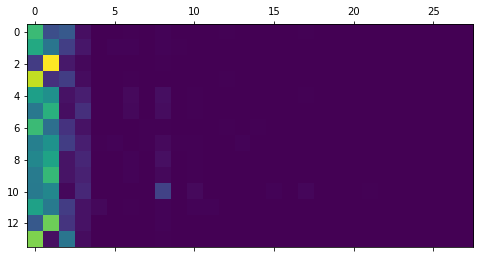

In [80]:
##Test heatmap
#idem peut être normalisation ? 
dicoTaxoTest = getDicoTaxo(df)
vecteurs = getNiv("Phylum",dicoTaxoTest)
mat = matrice(vecteurs)

plt.matshow(mat)

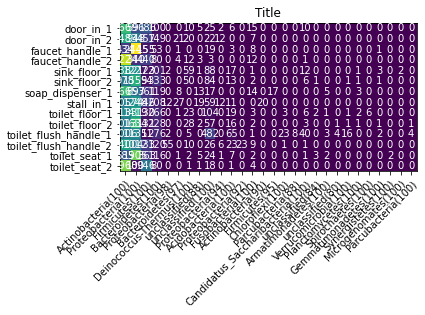

In [82]:
import matplotlib.pyplot as plt

##Test heatmap
dicoTaxoTest = getDicoTaxo(df)
vecteurs = getNiv("Phylum",dicoTaxoTest)
mat = matrice(vecteurs)

localisation = ["door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]

espece=vecteurs[0]

fig, ax = plt.subplots()
im = ax.imshow(mat)

ax.set_xticks(np.arange(len(espece)))
ax.set_yticks(np.arange(len(localisation)))

ax.set_xticklabels(espece)
ax.set_yticklabels(localisation)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(localisation)):
    for j in range(len(espece)):
        text = ax.text(j, i, mat[i, j],
                       ha="center", va="center", color="w")


ax.set_title("Title")
fig.tight_layout()
plt.show()        

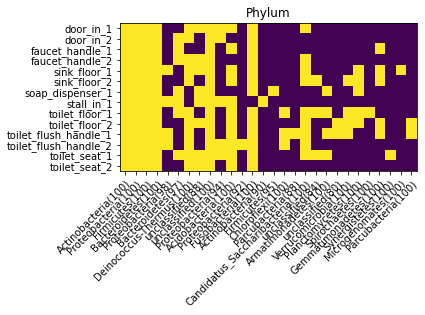

In [145]:
dicoTaxoTest = getDicoTaxo(df)
Niveau = "Phylum"
vecteurs = getNiv(Niveau,dicoTaxoTest)
mat = matrice(vecteurs)
newMat= []
for i in mat:
    listemat = []
    for j in i: 
        if j > 0:
            listemat.append(1)
        else:
            listemat.append(0)
    newMat.append(listemat)
    
localisation = ["door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]

espece=vecteurs[0]
newMatInverser=np.fliplr(np.rot90(newMat,3))
matinverser=np.fliplr(np.rot90(mat,3))

fig, ax = plt.subplots()
im = ax.imshow(newMat)

ax.set_xticks(np.arange(len(espece)))
ax.set_yticks(np.arange(len(localisation)))

ax.set_xticklabels(espece)
ax.set_yticklabels(localisation)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title(Niveau)
fig.tight_layout()
plt.show()  

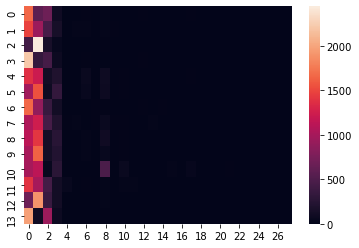

In [83]:
import seaborn as sns
##Test heatmap
dicoTaxoTest = getDicoTaxo(df)
vecteurs = getNiv("Phylum",dicoTaxoTest)
mat = matrice(vecteurs)
localisation = ["door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]

espece=vecteurs[0]

ax = sns.heatmap(mat)

In [110]:
#test treemap avec plotly
import matplotlib.cm as cm 
import matplotlib
import plotly.express as px 

dicoTaxoTest = getDicoTaxo(df)
df2 = getDF(dicoTaxoTest)
df3 = getDFTree(df2)

df4 = df3.drop(df3[df3['Nvx_taxo'] == 'regne'].index)
df4 = df4[df4.Comptage != '0']
df4['Comptage'] = pandas.to_numeric(df4['Comptage'], errors='coerce')
df4.sort_values('Comptage', ascending=False, inplace=True)


##Par localisation, taxo en courleur
fig = px.treemap(df4, path=['Localisation', 'Taxo'], 
                values='Comptage',
                color = 'Nvx_taxo')
##Par taxo, localisation en couleur
'''fig = px.treemap(df4, path=['Nvx_taxo', 'Taxo'], 
                values='Comptage',
                color = 'Localisation')'''
                
fig.show(renderer="svg")

'''fig = px.treemap(df2, path=['Nvx_taxo', 'Taxo'], 
                values='door_in_1')
fig.show()'''

ValueError: Image generation requires the psutil package.

Install using pip:
    $ pip install psutil

Install using conda:
    $ conda install psutil


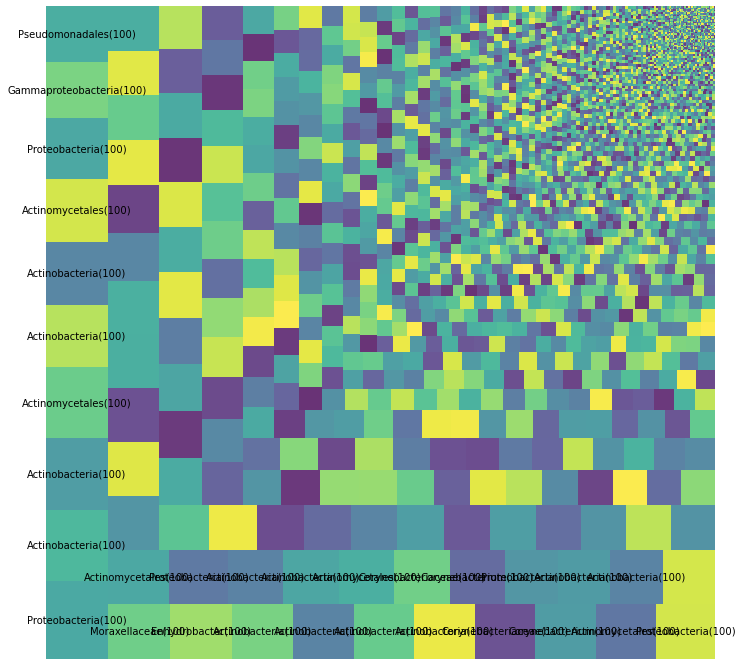

,Nvx_taxo,Taxo,Localisation,Comptage
2237,phylum,Proteobacteria(100),faucet_handle_1,2445
3047,classe,Actinobacteria(100),faucet_handle_2,2224
3046,phylum,Actinobacteria(100),faucet_handle_2,2224
3048,ordre,Actinomycetales(100),faucet_handle_2,2220
13197,classe,Actinobacteria(100),toilet_seat_2,1968
...,...,...,...,...
2214,famille,Acidimicrobiaceae(100),faucet_handle_1,1
4219,genre,Demequina(100),sink_floor_1,1
4218,famille,Demequinaceae(100),sink_floor_1,1
10545,genre,Croceicoccus(100),toilet_flush_handle_1,1


In [48]:
#test treemap avec plotly
import matplotlib.pyplot as plt
import squarify

dicoTaxoTest = getDicoTaxo(df)
df2 = getDF(dicoTaxoTest)
df3 = getDFTree(df2)

df4 = df3.drop(df3[df3['Nvx_taxo'] == 'regne'].index)
df4 = df4[df4.Comptage != '0']
df4['Comptage'] = pandas.to_numeric(df4['Comptage'], errors='coerce')
df4.sort_values('Comptage', ascending=False, inplace=True)

fig, ax = plt.subplots(1, figsize = (12,12))
squarify.plot(sizes=df4['Comptage'], 
              label=df4['Taxo'][:20], 
              alpha=.8 )

plt.axis('off')
plt.show()
df4

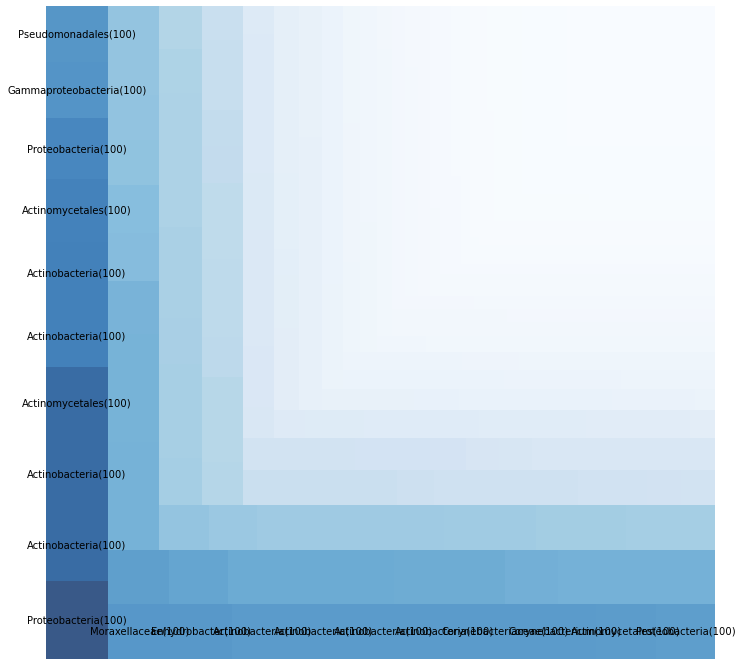

,Nvx_taxo,Taxo,Localisation,Comptage
2237,phylum,Proteobacteria(100),faucet_handle_1,2445
3047,classe,Actinobacteria(100),faucet_handle_2,2224
3046,phylum,Actinobacteria(100),faucet_handle_2,2224
3048,ordre,Actinomycetales(100),faucet_handle_2,2220
13197,classe,Actinobacteria(100),toilet_seat_2,1968
...,...,...,...,...
2214,famille,Acidimicrobiaceae(100),faucet_handle_1,1
4219,genre,Demequina(100),sink_floor_1,1
4218,famille,Demequinaceae(100),sink_floor_1,1
10545,genre,Croceicoccus(100),toilet_flush_handle_1,1


In [49]:
#test treemap
import squarify
import matplotlib.cm as cm 
import matplotlib

dicoTaxoTest = getDicoTaxo(df)
df2 = getDF(dicoTaxoTest)
df3 = getDFTree(df2)

df4 = df3.drop(df3[df3['Nvx_taxo'] == 'regne'].index)
df4 = df4[df4.Comptage != '0']
df4['Comptage'] = pandas.to_numeric(df4['Comptage'], errors='coerce')
df4.sort_values('Comptage', ascending=False, inplace=True)

cmap = cm.Blues
maxi=df4['Comptage'].max()
mini=df4['Comptage'].min()

norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in df4['Comptage']]

fig, ax = plt.subplots(1, figsize = (12,12))
squarify.plot(sizes=df4['Comptage'], 
              label=df4['Taxo'][:20], 
              alpha=.8 , color=colors)

plt.axis('off')
plt.show()

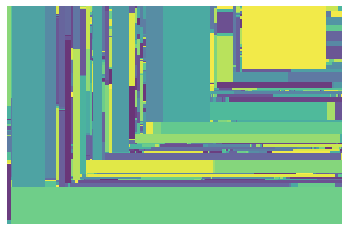

In [58]:
#test treemap
import squarify
import matplotlib.cm as cm 
import matplotlib

dicoTaxoTest = getDicoTaxo(df)
df2 = getDF(dicoTaxoTest)
df3 = getDFTree(df2)

df4 = df3.drop(df3[df3['Nvx_taxo'] == 'regne'].index)
df4 = df4[df4.Comptage != '0']
df4['Comptage'] = pandas.to_numeric(df4['Comptage'], errors='coerce')

n = df4.groupby('Taxo')[['Comptage']].sum().index.get_level_values(0).tolist()

b = df4.groupby('Taxo')[['Comptage']].sum().reset_index().Comptage.values.tolist()

squarify.plot(sizes=b,  alpha=.8)
plt.axis('off')
plt.show()

In [208]:
#test treemap avec plotly
import matplotlib.cm as cm 
import matplotlib
import plotly.express as px 

dicoTaxoTest = getDicoTaxo(df)
df2 = getDF(dicoTaxoTest)
df3 = getDFTree(df2)

#df4 = df3.drop(df3[df3['Nvx_taxo'] == 'regne'].index)

'''fig = px.treemap(df3, path=['Localisation', 'Taxo'], 
                values='Comptage',
                color = 'Nvx_taxo')
                
fig.show()'''
fig = px.treemap(df2, path=['Nvx_taxo', 'Taxo'], 
                values='door_in_1')
fig.show()

In [198]:
import requests
import pandas
import matplotlib.pyplot as plt
import numpy as np

df = pandas.read_csv("1335.vdb.tab", sep="\t", header =None) 
somme = 0
for index,row in df.iterrows():
    
    if index >0 : 
        somme = int(row[6]) + somme
somme
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,OTUNumber,OTUConTaxonomy,door_in_1,door_in_2,faucet_handle_1,faucet_handle_2,sink_floor_1,sink_floor_2,soap_dispenser_1,stall_in_1,toilet_floor_1,toilet_floor_2,toilet_flush_handle_1,toilet_flush_handle_2,toilet_seat_1,toilet_seat_2
1,Otu00001,Bacteria(100);Actinobacteria(100);Actinobacter...,1381,1032,335,577,38,36,1115,598,45,87,13,329,76,156
2,Otu00002,Bacteria(100);Proteobacteria(100);Gammaproteob...,20,17,1686,3,411,564,128,9,430,707,0,25,258,0
3,Otu00003,Bacteria(100);Actinobacteria(100);Actinobacter...,8,47,6,418,15,8,84,45,6,30,3,283,41,1059
4,Otu00004,Bacteria(100);Actinobacteria(100);Actinobacter...,6,27,5,6,452,275,63,0,236,251,9,51,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4101,Otu04101,Bacteria(100);Bacteroidetes(100);Cytophagia(10...,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4102,Otu04102,Bacteria(100);Proteobacteria(100);Alphaproteob...,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4103,Otu04103,Bacteria(100);Firmicutes(100);unclassified(100...,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4104,Otu04104,Bacteria(100);Acidobacteria(100);Acidobacteria...,0,0,0,0,0,1,0,0,0,0,0,0,0,0


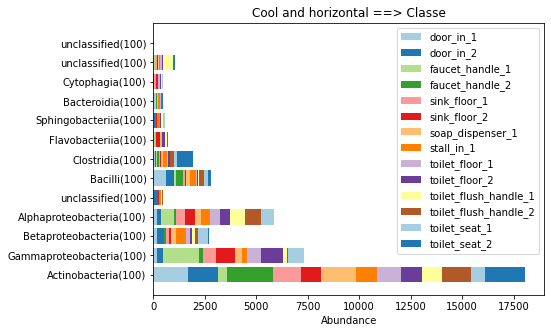

In [144]:
import plotly as pt
import seaborn as sns
import matplotlib.pyplot as plt
##Test plotBare HOrizontal Complet

SELECTED = "Classe" #cette fois Ordre
dicoTaxoTest = getDicoTaxo(df)
vecteurs = getNiv(SELECTED,dicoTaxoTest) 

localisation=["door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]

vecteursTrier = abondanceImportant(vecteurs)
selected_niv=vecteursTrier[0]
N=len(selected_niv)
ind = np.arange(N)

l_loc = []
for i in range(len(localisation)):
    l_loc.append(vecteursTrier[i+1]) #car vecteursTrier[1] --> "door_in_1"
    

height = 0.8
fig = plt.figure(figsize=[7,5])
bars = []
cols = sns.color_palette("Paired",14) #COLORS
tmpbarobject = plt.barh(ind,l_loc[0], height,color=cols[0])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[1],height, left= l_loc[0], color=cols[1])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[2],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1])], color=cols[2])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[3],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1],l_loc[2])], color=cols[3])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[4],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1],l_loc[2],l_loc[3])], color=cols[4])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[5],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1],l_loc[2],l_loc[3],l_loc[4])], color=cols[5])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[6],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1],l_loc[2],l_loc[3],l_loc[4],l_loc[5])], color=cols[6])
bars.append(tmpbarobject[0]) 
tmpbarobject = plt.barh(ind, l_loc[7],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1],l_loc[2],l_loc[3],l_loc[4],l_loc[5],l_loc[6])], color=cols[7])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[8],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1],l_loc[2],l_loc[3],l_loc[4],l_loc[5],l_loc[6],l_loc[7])], color=cols[8])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[9],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1],l_loc[2],l_loc[3],l_loc[4],l_loc[5],l_loc[6],l_loc[7],l_loc[8])], color=cols[9])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[10],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1],l_loc[2],l_loc[3],l_loc[4],l_loc[5],l_loc[6],l_loc[7],l_loc[8],l_loc[9])], color=cols[10])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[11],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1],l_loc[2],l_loc[3],l_loc[4],l_loc[5],l_loc[6],l_loc[7],l_loc[8],l_loc[9],l_loc[10])], color=cols[11])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[12],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1],l_loc[2],l_loc[3],l_loc[4],l_loc[5],l_loc[6],l_loc[7],l_loc[8],l_loc[9],l_loc[10],l_loc[11])], color=cols[12])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[13],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1],l_loc[2],l_loc[3],l_loc[4],l_loc[5],l_loc[6],l_loc[7],l_loc[8],l_loc[9],l_loc[10],l_loc[11],l_loc[12])], color=cols[13])
bars.append(tmpbarobject[0])


plt.xlabel('Abundance') 
plt.title('Cool and horizontal ==> ' + SELECTED) 
plt.yticks(ind, (selected_niv)) 

plt.legend(bars, localisation) 
  
plt.show()

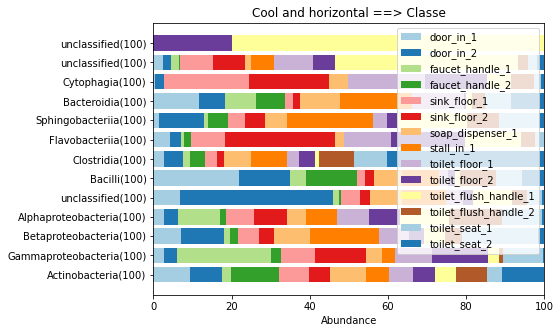

In [147]:
import plotly as pt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
##Test plotBare HOrizontal Complet

SELECTED = "Classe" #cette fois Ordre
dicoTaxoTest = getDicoTaxo(df)
vecteurs = getNiv(SELECTED,dicoTaxoTest) 

localisation=["door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]

vecteursTrier = abondanceImportant(vecteurs)
selected_niv=vecteursTrier[0]
N=len(selected_niv)
ind = np.arange(N)

l_loc = []
total = [sum(x) for x in zip( vecteursTrier[1],vecteursTrier[2],vecteursTrier[3],vecteursTrier[4],vecteursTrier[5],vecteursTrier[6],vecteursTrier[7],vecteursTrier[8],vecteursTrier[9],vecteursTrier[10],vecteursTrier[11],vecteursTrier[12],vecteursTrier[13],vecteursTrier[14])]
for i in range(len(localisation)):
    l_loc.append(np.true_divide(vecteursTrier[i+1],total)*100) #car vecteursTrier[1] --> "door_in_1"
    

height = 0.8
fig = plt.figure(figsize=[7,5])
bars = []
cols = sns.color_palette("Paired",14) #COLORS
tmpbarobject = plt.barh(ind,l_loc[0], height,color=cols[0])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[1],height, left= l_loc[0], color=cols[1])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[2],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1])], color=cols[2])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[3],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1],l_loc[2])], color=cols[3])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[4],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1],l_loc[2],l_loc[3])], color=cols[4])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[5],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1],l_loc[2],l_loc[3],l_loc[4])], color=cols[5])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[6],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1],l_loc[2],l_loc[3],l_loc[4],l_loc[5])], color=cols[6])
bars.append(tmpbarobject[0]) 
tmpbarobject = plt.barh(ind, l_loc[7],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1],l_loc[2],l_loc[3],l_loc[4],l_loc[5],l_loc[6])], color=cols[7])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[8],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1],l_loc[2],l_loc[3],l_loc[4],l_loc[5],l_loc[6],l_loc[7])], color=cols[8])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[9],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1],l_loc[2],l_loc[3],l_loc[4],l_loc[5],l_loc[6],l_loc[7],l_loc[8])], color=cols[9])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[10],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1],l_loc[2],l_loc[3],l_loc[4],l_loc[5],l_loc[6],l_loc[7],l_loc[8],l_loc[9])], color=cols[10])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[11],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1],l_loc[2],l_loc[3],l_loc[4],l_loc[5],l_loc[6],l_loc[7],l_loc[8],l_loc[9],l_loc[10])], color=cols[11])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[12],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1],l_loc[2],l_loc[3],l_loc[4],l_loc[5],l_loc[6],l_loc[7],l_loc[8],l_loc[9],l_loc[10],l_loc[11])], color=cols[12])
bars.append(tmpbarobject[0])
tmpbarobject = plt.barh(ind, l_loc[13],height, left= [sum(x) for x in zip(l_loc[0], l_loc[1],l_loc[2],l_loc[3],l_loc[4],l_loc[5],l_loc[6],l_loc[7],l_loc[8],l_loc[9],l_loc[10],l_loc[11],l_loc[12])], color=cols[13])
bars.append(tmpbarobject[0])


plt.xlabel('Abundance') 
plt.title('Cool and horizontal ==> ' + SELECTED) 
plt.yticks(ind, (selected_niv)) 

plt.legend(bars, localisation) 
  
plt.show()

In [151]:
dicoTaxoTest = getDicoTaxo(df)
df2 = getDF(dicoTaxoTest)
filtre = df2['Nvx_taxo']=='classe'
dfClasse = df2[filtre]
dfTaxo = dfClasse.copy()
listColonneSupTaxo=["Nvx_taxo", "door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]
dfTaxo.drop(columns = listColonneSupTaxo, inplace = True)
listColonne = ["door_in_2",  
                "faucet_handle_2",  "sink_floor_2",
               "toilet_floor_2", 
               "toilet_flush_handle_2", "toilet_seat_2"]
dfClasseLoc = dfClasse.drop(columns =listColonne , inplace= True )


0                        Bacteria
1             Actinobacteria(100)
2             Actinobacteria(100)
3            Actinomycetales(100)
4       Propionibacteriaceae(100)
                  ...            
1010           Parcubacteria(100)
1011            unclassified(100)
1012            unclassified(100)
1013            unclassified(100)
1014            unclassified(100)
Name: Taxo, Length: 1015, dtype: object

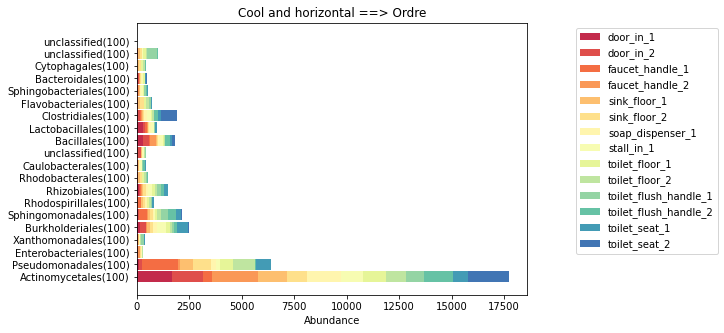

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

SELECTED = "Ordre" 
dicoTaxoTest = getDicoTaxo(df)
vecteurs = getNiv(SELECTED,dicoTaxoTest) 

localisation=["door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]

vecteursTrier = abondanceImportant(vecteurs, 250)
selected_niv=vecteursTrier[0]
N=len(selected_niv)
ind = np.arange(N)

l_loc = []
for i in range(len(localisation)):
    l_loc.append(vecteursTrier[i+1]) #car vecteursTrier[1] --> "door_in_1"
    

height = 0.9
fig = plt.figure(figsize=[7, 5])
bars = []
cols = sns.color_palette("Spectral",14) #COLORS
#NOTE:max colors for "colorblind" are 10, look for solution soon!
cumulated = np.zeros(len(l_loc[0]),dtype=int)
for i in range(len(localisation)):
    if i == 0 :
        tmpbarobject = plt.barh(ind,l_loc[i], height,color=cols[i])
    else: 
        tmpbarobject = plt.barh(ind, l_loc[i],height, left=cumulated, color=cols[i]) 

    cumulated = np.add(l_loc[i],cumulated)
    bars.append(tmpbarobject[0])

plt.xlabel('Abundance') 
plt.title('Cool and horizontal ==> ' + SELECTED) 
plt.yticks(ind, (selected_niv)) 
# legende dehors du plot area avec: bbbox_to_anchor
plt.legend(bars, localisation, bbox_to_anchor=(1.5, 1)) 

TypeError: unsupported operand type(s) for +: 'int' and 'list'

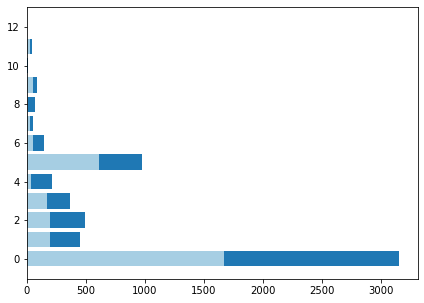

In [40]:
import plotly as pt
import seaborn as sns
import matplotlib.pyplot as plt
##Test plotBare HOrizontal Complet

SELECTED = "Classe" #cette fois Ordre
dicoTaxoTest = getDicoTaxo(df)
vecteurs = getNiv(SELECTED,dicoTaxoTest) 

localisation=["door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]

vecteursTrier = abondanceImportant(vecteurs)
selected_niv=vecteursTrier[0]
N=len(selected_niv)
ind = np.arange(N)

l_loc = []
for i in range(len(localisation)):
    l_loc.append(vecteursTrier[i+1]) #car vecteursTrier[1] --> "door_in_1"
    

height = 0.8
fig = plt.figure(figsize=[7,5])
bars = []
cols = sns.color_palette("Paired",14) #COLORS
for i in range(len(localisation)):
    if i == 0 :
        tmpbarobject = plt.barh(ind,l_loc[0], height,color=cols[0])
    elif i == 1:
        tmpbarobject = plt.barh(ind, l_loc[1],height, left= l_loc[0], color=cols[1])
    elif i > 1:
        tmpbarobject = plt.barh(ind, l_loc[i],height, left= [sum(x) for x in zip(l_loc[i] for i in range(0, i-1))], color=cols[i])
    bars.append(tmpbarobject[0])

plt.xlabel('Abundance') 
plt.title('Cool and horizontal ==> ' + SELECTED) 
plt.yticks(ind, (selected_niv)) 

plt.legend(bars, localisation) 
  
plt.show()


,Nvx_taxo,Taxo,Comptage,Localisation
0,regne,Bacteria,door_in_1,3119
1,phylum,Actinobacteria(100),door_in_1,1669
2,classe,Actinobacteria(100),door_in_1,1669
3,ordre,Actinomycetales(100),door_in_1,1658
4,famille,Propionibacteriaceae(100),door_in_1,1398
...,...,...,...,...
14205,phylum,Parcubacteria(100),toilet_seat_2,0
14206,classe,unclassified(100),toilet_seat_2,0
14207,ordre,unclassified(100),toilet_seat_2,0
14208,famille,unclassified(100),toilet_seat_2,0


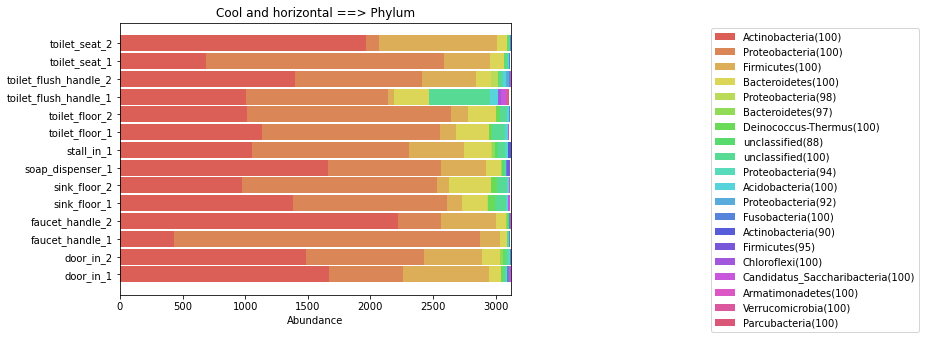

In [116]:
"""
Création de differente figures
"""
import matplotlib.pyplot as plt
import seaborn as sns

SELECTED = "Phylum" 
dicoTaxoTest = getDicoTaxo(df)
vecteurs = getNiv(SELECTED,dicoTaxoTest) 



localisation=["door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]

vecteursTrier = abondanceImportant(vecteurs, 10)

vecteursTaxo = vecteursTrier[0]
vecteursComptage = np.delete(vecteursTrier, (0), axis=0)
VecteursComptInverse=np.fliplr(np.rot90(vecteursComptage,3))

N=len(VecteursComptInverse[0])
ind = np.arange(N)

l_loc = []
for i in range(len(vecteursTaxo)):
    l_loc.append(VecteursComptInverse[i])

height = 0.9
fig = plt.figure(figsize=[7, 5])
bars = []
cols = sns.color_palette("hls",len(vecteursTaxo)) #COLORS
#NOTE:max colors for "colorblind" are 10, look for solution soon!
cumulated = np.zeros(len(l_loc[0]),dtype=int)
for i in range(len(vecteursTaxo)):
    if i == 0 :
        tmpbarobject = plt.barh(ind,[int(elem) for elem in l_loc[i] ], height,color=cols[i])
    else: 
        tmpbarobject = plt.barh(ind, [int(elem) for elem in l_loc[i] ],height, left=cumulated, color=cols[i]) 
    
    listeInt= [int(elem) for elem in l_loc[i] ]
    cumulated = np.add(listeInt,cumulated)
    bars.append(tmpbarobject[0])
        

plt.xlabel('Abundance') 
plt.title('Cool and horizontal ==> ' + SELECTED) 
plt.yticks(ind, (localisation)) 
# legende dehors du plot area avec: bbbox_to_anchor
plt.legend(bars, vecteursTaxo, bbox_to_anchor=(1.5, 1))    
    

In [32]:
#Recupère les donnéer et format en Df
dicoTaxoTest = getDicoTaxo(df)
dfEntier= getDF(dicoTaxoTest)

#Création DF avec seulement les comptage pour le phylum (dfComptage)
dfComptage = getDFFonctionTaxo(dfEntier, "phylum")
listeColonneSuprimer = ["Nvx_taxo","Taxo"]
dfComptage = getDFLoc(dfComptage,listeColonneSuprimer )

#Creéation DF avec seulement les noms des phylum (dfTaxo)
dfTaxo = getDFFonctionTaxo(dfEntier, "phylum")
listeColonneSuprimerPourTaxo = ["Nvx_taxo","door_in_1","door_in_2", "faucet_handle_1", "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", "toilet_floor_2", "toilet_flush_handle_1","toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]
dfTaxo = getDFLoc(dfTaxo,listeColonneSuprimerPourTaxo )

dfComptage
dfTaxo

,Taxo
1,Actinobacteria(100)
207,Proteobacteria(100)
559,Firmicutes(100)
689,Bacteroidetes(100)
795,Proteobacteria(98)
800,Bacteroidetes(97)
805,Deinococcus-Thermus(100)
824,unclassified(88)
829,unclassified(100)
834,Proteobacteria(94)
